In [ ]:
import cv2 as cv2
from PIL import Image
import numpy as np
import os
import shutil
from google.colab.patches import cv2_imshow
import tensorflow as tf


In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/dataset/final.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/dataset/classification_words.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/words')

In [ ]:
# Copying top 25000 image from final in temp

# For Words
folder_path = '/tmp/words/tmp/words'
!mkdir /tmp/words-25K-Images

# For Formulas
# folder_path = '/tmp/final'
# !mkdir /tmp/formula-25K-Images

file_list = os.listdir(folder_path)
count = 0;
for file_name in file_list:
  if count == 25000:
    break
  # For Formulas
  # source_file_path = f'/tmp/final/{file_name}'
  # destination_folder_path = '/tmp/formula-25K-Images'
  # For Words
  source_file_path = f'/tmp/words/tmp/words/{file_name}'
  destination_folder_path = '/tmp/words-25K-Images'
  file_name = os.path.basename(source_file_path)
  destination_file_path = os.path.join(destination_folder_path, file_name)
  shutil.copyfile(source_file_path, destination_file_path)
  count = count + 1

In [ ]:
# For displaying the images in the formula-25K-Images
# !ls /tmp/formula-25K-Images
# For displaying the images in the words-25K-Images
# !ls /tmp/words/tmp/words

In [ ]:
# USE THIS TO REMOVE ALL THE FILES FROM THE FORMULA 1OK IMAGES
folder_path = '/tmp/train/words'
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    os.remove(file_path)

In [ ]:
# import os
# For Formula
# folder_path = '/tmp/formula-25K-Images'
# For Words
# folder_path = '/tmp/words-25K-Images'
# files = os.listdir(folder_path)
# num_files = len(files)
# print(f'The folder contains {num_files} files.')

The folder contains 25000 files.


Data Preprocessing Resizing the Image

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)

    return image

In [ ]:
# file_path = '/tmp/formula-10K-Images/10072d7334.png'
# image = cv2.imread(file_path)
# cv2_imshow(image)
# resized_image = distortion_free_resize(image,[224,224])

In [ ]:
!mkdir /tmp/train

In [ ]:
!mkdir /tmp/test

In [ ]:
!mkdir /tmp/test/words
count = 0
for path in os.listdir('/tmp/words-25K-Images'):
  if count == 10000:
    break
  # For Words 
  source_file_path = f'/tmp/words-25K-Images/{path}'
  image = cv2.imread(f'/tmp/words-25K-Images/{path}')
  # For Formula
  # source_file_path = f'/tmp/formula-25K-Images/{path}'
  # image = cv2.imread(f'/tmp/formula-25K-Images/{path}')
  image = distortion_free_resize(image,[224,224])
  image = image.numpy()
  image = cv2.imwrite(f'/tmp/test/words/{path}',image)
  print(count)
  count = count + 1

In [ ]:
# import os
# For Formula
# folder_path = '/tmp/train/formula'
# For Words
# folder_path = '/tmp/train/words'
# files = os.listdir(folder_path)
# num_files = len(files)
# print(f'The folder contains {num_files} files.')
# image = cv2.imread(f'/tmp/train/words/{files[0]}')
# cv2_imshow(image)
# image.shape

In [ ]:
# import shutil
# temp_dir_path = '/tmp/train'
# dest_dir_path = '/content/drive/MyDrive'
# shutil.copytree(temp_dir_path, dest_dir_path)
# print(f'Successfully copied the directory from {temp_dir_path} to {dest_dir_path}.')

# import zipfile
# file_path = '/tmp/train/'
# zip_file_path = '/content/drive/MyDrive/VikramTrain.zip'

# with zipfile.ZipFile(zip_file_path, 'w') as zip_file:
#     zip_file.write(file_path)
# print(f'Successfully zipped {file_path} to {zip_file_path}.')


Successfully zipped /tmp/train/ to /content/drive/MyDrive/VikramTrain.zip.


VGG 16 STARTS FROM HERE

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
train_path = '/tmp/train'
valid_path = '/tmp/test'

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/tmp/train/*')
print(folders)

['/tmp/train/words', '/tmp/train/formula']


In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/tmp/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 50000 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/tmp/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 20000 images belonging to 2 classes.


In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-42-89113a27acbd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
1563/1563 [==============================] - 700s 440ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0087 - val_accuracy: 0.9969
Epoch 2/5
1563/1563 [==============================] - 694s 444ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 7.9170e-04 - val_accuracy: 0.9996
Epoch 3/5
1563/1563 [==============================] - 680s 435ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 2.1680e-04 - val_accuracy: 0.9999
Epoch 4/5
1563/1563 [==============================] - 679s 434ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0204 - val_accuracy: 0.9965
Epoch 5/5
1563/1563 [==============================] - 677s 433ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 2.2448e-05 - val_accuracy: 1.0000


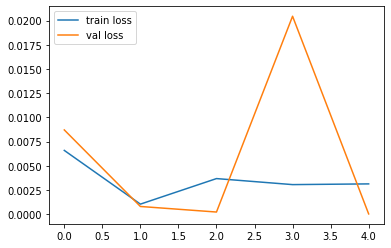

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
# plt.plot(r.history['acc'], label='train acc')
# plt.plot(r.history['val_acc'], label='val acc')
# plt.legend()
# plt.show()
# plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new_model.h5')

Testing of model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/dataset/vikram/Classification.h5')

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def predict(image):
  image = distortion_free_resize(image,(224,224)).numpy()
  image = np.reshape(image,(1,224,224,3))
  preds = model.predict(image)
  l = np.argmax(np.array(preds[0]))
  if l==0:
    return "Formula"
  else:
    return "Word"

In [ ]:
import os 
for path in os.listdir('/content/files'):
  file_path = os.path.join('/content/files',path)
  image = cv2.imread(file_path)
  prediction = predict(image)
  cv2_imshow(image)
  print(prediction)